<a href="https://colab.research.google.com/github/demotu/gait_score/blob/main/notebooks/gps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Gait Score Neuropathy (gait_score): GPS calculation

## Python setup

In [1]:
#@title ### Import libraries {display-mode: "form"}
import sys, os
from pathlib import Path  # file and directory paths in Python
import glob  # Unix style pathname pattern expansion
from datetime import datetime
import numpy as np  # large, multi-dimensional numeric arrays and matrices
import pandas as pd  # labelled tables with numeric and string data
import matplotlib  # data visualization
import matplotlib.pyplot as plt  # data visualization
import seaborn as sns  # data visualization
import xarray as xr  # labelled multi-dimensional arrays
from tqdm.notebook import tqdm  # progress bar
from IPython.display import display, Math, Latex  # IPython formatting
import scipy as sp  # collection of mathematical algorithms and convenience functions built on NumPy

print(f'Python {sys.version} on {sys.platform}', f' numpy {np.__version__}',
      f' scipy {sp.__version__}', f' pandas {pd.__version__}',
      datetime.now().strftime("%d/%m/%Y %H:%M:%S"), sep='\n')

Python 3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 15:55:29) [Clang 17.0.6 ] on darwin
 numpy 2.1.3
 scipy 1.14.1
 pandas 2.2.3
23/11/2024 16:48:09


In [2]:
#@title ### Environment configuration {display-mode: "form"}
sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 2})
sns.set_style('whitegrid')
colors = sns.color_palette()
display(colors)
style = [{'selector': 'th', 'props': [('text-align', 'left')]},
         {'selector': 'caption', 'props': [('font-weight', 'bold'), ('color', 'blue'), ('font-size', '120%')]}]
xr.set_options(keep_attrs=True)
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

# angle convention
planes  = ['Sagittal', 'Frontal', 'Transverse']
labels_gps_kin = np.array(['Pelvic Tilt', 'Pelvic Obliquity', 'Pelvic Rotation',
                           'Hip Flexion', 'Hip Adduction', 'Hip Rotation',
                           'Knee Flexion', 'Ankle Dorsiflexion', 'Foot Progression', 'GPS'])
labels_gps_mom = np.array(['Hip', 'Knee', 'Ankle', 'Support', 'GPS'])
labels_kin  = np.array([['Pelvic Tilt ($^o$)\npost(-)/ant(+)',
                         'Pelvic Obliquity ($^o$)\ndown(-)/up(+)',
                         'Pelvic Rotation ($^o$)\next(-)/int(+)'],
                        ['Hip Flexion ($^o$)\next(-)/flex(+)',
                         'Hip Adduction ($^o$)\nabd(-)/add(+)',
                         'Hip Rotation ($^o$)\next(-)/int(+)'],
                        ['Knee Flexion ($^o$)\next(-)/flex(+)',
                         'Ankle Dorsiflexion ($^o$)\nplantarflex(-)/dorsiflex(+)',
                         'Foot Progression ($^o$)\nint(-)/ext(+)']])
labels_mom = np.array([['Hip ($Nm/BM$)\next(-)/flex(+)',
                        'Knee ($Nm/BM$)\next(-)/flex(+)',
                        'Ankle ($Nm/BM$)\nplantarflex(-)/dorsiflex(+)',
                        'Support ($Nm/BM$)\next(-)/flex(+)']]).T

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
#@title ### Helping functions {display-mode: "form"}
def read_data(path2, fname, variable=None):
    if os.getenv("COLAB_RELEASE_TAG"):
        url = f'https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/metadata_{fname}.csv'
        print(f'Loading data from {url}')
        metadata = pd.read_csv(url, sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
    else:
        metadata = pd.read_csv(path2 /  f'metadata_{fname}.csv', sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
    if os.getenv("COLAB_RELEASE_TAG"):
        url = f'https://github.com/demotu/gait_score/raw/refs/heads/main/data/{variable}_{fname}.nc'
        #print(f'Loading data from {url}')
        !wget {url}
        da = xr.open_dataarray(f'{variable}_{path2.name}.nc')
    else:
        da = xr.open_dataarray(path2 / f'{variable}_{fname}.nc')
    return metadata, da


def gps_calc(da2, ref, metadata2, labels_gps):
    """
    """
    subjects = metadata2['Subject'].unique()
    NS = subjects.size
    time = da2['Time'].values
    joints = list(da2.Joint.values)
    axes = list(da2.Axis.values)
    gvs = np.full((NS, labels_gps.size), np.nan)
    for s, subject in enumerate(subjects):
        x = da2.sel(Subject=subject).values.reshape(time.size, len(joints)*len(axes))
        gvs[s, :-1] = RMSD(x, ref.values)
    
    gvs[:, -1] = np.sqrt(np.mean(gvs[:, :-1]**2, axis=1))
    gvs = pd.DataFrame(data=gvs, index=subjects, columns=labels_gps)
    #gvs_m = np.sqrt(np.mean(gvs**2, axis=0))
    #gvs_std = np.sqrt(np.std(gvs**2, axis=0, ddof=1))
    gvs_m = np.percentile(gvs, 50, axis=0)
    gvs_std = np.percentile(gvs, [25, 75], axis=0)

    return gvs, gvs_m, gvs_std
    
    
def plot_gps(gvs, gvs_m, gvs_std, metadata2, path2, hist=True, MAP=True, prefix='', units='$^o$'):
    """
    """
    if units == '$^o$':
        prefix2 = 'Angles: '
    else:
        prefix2 = 'Moments of force: '
    subjects = metadata2['Subject'].unique()
    NS = subjects.size    
    if hist:
        axs = gvs.hist(layout=(int(gvs.shape[1]/5), 5), figsize=(12, np.ceil(gvs.shape[1]/2)))
        for ax in axs[:, 0]:
            ax.set_ylabel('Frequency')
        for ax in axs[-1, :]:
            ax.set_xlabel(f'RMS difference ({units})')        
        plt.suptitle(f'{prefix2}{prefix}Histograms for GVS and GPS values ({NS} subjects)')
        plt.tight_layout()
        plt.show()
    if MAP:
        fig, axs = plt.subplots(1, 1, figsize=(6, 4))
        x = np.r_[np.arange(1, gvs.shape[1]), gvs.shape[1]+1]
        #x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11]
        axs.bar(x=x, height=gvs_m, yerr=gvs_std, width=.8, edgecolor=None, capsize=5)
        axs.set_ylabel(f'RMS difference ({units})')
        axs.set_xlabel('')
        axs.xaxis.set_ticks(x)
        axs.set_xticklabels(gvs.columns.values, rotation=45, ha='right')
        axs.grid(True)
        plt.suptitle(f'{prefix2}{prefix}Movement analysis profile ({NS} subjects)')
        plt.tight_layout()
        plt.show()   


def plot_ensembles2(da2, metadata, path2, mean=False, ref=None, prefix=''):
    """3x3 suplots with joint angles of all subjects for the GPS calculation.
    """

    time = da2['Time'].values
    joints = list(da2.Joint.values)
    axes = list(da2.Axis.values)

    NS = metadata['Subject'].unique().size
    NT = metadata['Subject'].shape[0]
    fig, axs = plt.subplots(3, 3, figsize=(12, 9), sharex=True)
    text = f'{path2.name}:'
    if ref is not None:
        ref_m =  ref.values[:, 0::2]
        ref_sd = ref.values[:, 1::2]
    if mean:
        text = f'{prefix}Joint angles during walking (mean$\\pm$1SD across subjects, {NS} subjects with neuropathy) and mean of control'
    else:
        text = f'{prefix}Subjects\' joint angles during walking (median across trials, {NS} subjects, {NT} trials)'
    fig.suptitle(text, fontsize=12)
    for j, joint in enumerate(joints):
        for xyz, eixo in enumerate(axes):
            axs[j, xyz].axhline(y=0, color=[0, 0, 0, .6], linestyle='-', lw=1, zorder=-1)
            axs[j, xyz].axvline(x=np.round(np.nanmean(metadata['Foot Off'])), color=[0, 0, 0, .6], linestyle=':', lw=1, zorder=-1)
            
            if ref is not None:
                axs[j, xyz].plot(time, ref_m[:, 3*j+xyz], color=colors[1], alpha=.5, lw=3, label='Control')
                if mean:
                    axs[j, xyz].fill_between(time,
                                             ref_m[:, 3*j+xyz] + ref_sd[:, 3*j+xyz],
                                             ref_m[:, 3*j+xyz] - ref_sd[:, 3*j+xyz],
                                             facecolor=colors[1], alpha=.3, edgecolor='none')
            
            if mean:
                dam = da2.reduce(np.nanmean, dim='Subject')
                dastd = da2.reduce(np.nanstd, ddof=1, dim='Subject')#/np.sqrt(NS)
                axs[j, xyz].plot(time, dam.sel(Joint=joints[j], Axis=axes[xyz]), color=colors[0], alpha=.8, lw=3, label='Neuropathy')
                axs[j, xyz].fill_between(time,
                                         dam.sel(Joint=joints[j], Axis=axes[xyz]) + dastd.sel(Joint=joints[j], Axis=axes[xyz]),
                                         dam.sel(Joint=joints[j], Axis=axes[xyz]) - dastd.sel(Joint=joints[j], Axis=axes[xyz]),
                                         facecolor=colors[0], alpha=.6, edgecolor='none')
            else:
                axs[j, xyz].plot(time, da2.sel(Joint=joints[j], Axis=axes[xyz]), alpha=.6, lw=2)

            axs[j, xyz].set_ylabel(labels[j][xyz], fontsize=12)
            axs[j, xyz].set_xlim([0, 100])
            if xyz == 0:
                axs[j, xyz].margins(y=0.25)
            else:
                axs[j, xyz].margins(y=0.25)
            axs[j, xyz].grid(False)
            axs[j, xyz].xaxis.set_ticks_position('none')
            axs[j, xyz].yaxis.set_ticks_position('none')
            axs[j, xyz].tick_params(axis='both', which='major', pad=0)
            if j == 2 and xyz == 1:
                axs[j, xyz].set_xlabel('Gait cycle [%]', fontsize=14)
                axs[j, xyz].xaxis.set_label_coords(.5, -.2)

    fig.align_ylabels()
    if ref is not None:
        axs[0, 1].legend(loc='upper right', framealpha=1, frameon=False)
    fig.tight_layout()
    try:
        if mean:
            fig.savefig(f'{path2}Angles_msd_Subjects_{prefix}.png', bbox_inches='tight')
        else:
            fig.savefig(f'{path2}AnglesSubjectsG_{prefix}.png', bbox_inches='tight')
    except:
        print('Figure not saved in the cloud.')
    plt.show()



def plot_ensembles(da2, metadata, path2, mean=False, labels=None, ref=None, prefix='', variable=None):
    """3x3 suplots with joint angles of all subjects for the GPS calculation.
    """

    time = da2['Time'].values
    joints = list(da2.Joint.values)
    axes = list(da2.Axis.values)

    NS = metadata['Subject'].unique().size
    NT = metadata['Subject'].shape[0]
    fig, axs = plt.subplots(len(joints), len(axes), figsize=(len(axes)*4, 9), sharex=True, squeeze=False)
    text = f'{path2.name}:'
    if ref is not None:
        ref_m =  ref.values[:, 0::2]
        ref_sd = ref.values[:, 1::2]
    if mean:
        text = f'{prefix}Joint {variable} during walking (mean$\\pm$1SD across subjects, {NS} subjects with neuropathy) and mean of control'
    else:
        text = f'{prefix}Subjects\' joint {variable} during walking (median across trials, {NS} subjects, {NT} trials)'
    fig.suptitle(text, fontsize=12)
    for j, joint in enumerate(joints):
        for xyz, eixo in enumerate(axes):
            axs[j, xyz].axhline(y=0, color=[0, 0, 0, .6], linestyle='-', lw=1, zorder=-1)
            axs[j, xyz].axvline(x=np.round(np.nanmean(metadata['Foot Off'])), color=[0, 0, 0, .6], linestyle=':', lw=1, zorder=-1)
            
            if ref is not None:
                axs[j, xyz].plot(time, ref_m[:, len(axes)*j+xyz], color=colors[1], alpha=.5, lw=3, label='Control')
                axs[j, xyz].fill_between(time,
                                         ref_m[:, len(axes)*j+xyz] + ref_sd[:, len(axes)*j+xyz],
                                         ref_m[:, len(axes)*j+xyz] - ref_sd[:, len(axes)*j+xyz],
                                         facecolor=colors[1], alpha=.3, edgecolor='none')
            
            if mean:
                dam = da2.reduce(np.nanmean, dim='Subject')
                dastd = da2.reduce(np.nanstd, ddof=1, dim='Subject')#/np.sqrt(NS)
                axs[j, xyz].plot(time, dam.sel(Joint=joints[j], Axis=axes[xyz]), color=colors[0], alpha=.8, lw=3, label='Neuropathy')
                axs[j, xyz].fill_between(time,
                                         dam.sel(Joint=joints[j], Axis=axes[xyz]) + dastd.sel(Joint=joints[j], Axis=axes[xyz]),
                                         dam.sel(Joint=joints[j], Axis=axes[xyz]) - dastd.sel(Joint=joints[j], Axis=axes[xyz]),
                                         facecolor=colors[0], alpha=.6, edgecolor='none')
            else:
                axs[j, xyz].plot(time, da2.sel(Joint=joints[j], Axis=axes[xyz]), alpha=.6, lw=2)

            axs[j, xyz].set_ylabel(labels[j][xyz], fontsize=12)
            axs[j, xyz].set_xlim([0, 100])
            if xyz == 0:
                axs[j, xyz].margins(y=0.25)
            else:
                axs[j, xyz].margins(y=0.25)
            axs[j, xyz].grid(False)
            axs[j, xyz].xaxis.set_ticks_position('none')
            axs[j, xyz].yaxis.set_ticks_position('none')
            axs[j, xyz].tick_params(axis='both', which='major', pad=0)
            if j == 2 and xyz == 1:
                axs[j, xyz].set_xlabel('Gait cycle [%]', fontsize=14)
                axs[j, xyz].xaxis.set_label_coords(.5, -.2)

    fig.align_ylabels()
    if ref is not None:
        axs[0, 0].legend(loc='upper right', framealpha=1, frameon=False)
    fig.tight_layout()
    try:
        if mean:
            fig.savefig(f'{path2}Angles_msd_Subjects_{prefix}.png', bbox_inches='tight')
        else:
            fig.savefig(f'{path2}AnglesSubjectsG_{prefix}.png', bbox_inches='tight')
    except:
        print('Figure not saved in the cloud.')
    plt.show()


## The Gait Proﬁle Score (GPS)

Baker et al. (2009) proposed the Gait Proﬁle Score (GPS) as an index of overall gait pathology.  
To calculate the GPS, first the Gait Variable Score (GVS) is determined as the RMS difference between a gait variable of a subject and the average of this gait variable for a sample with no gait pathology (reference).  
The Gait Proﬁle Score (GPS) is the RMS average of all GVS values.  
The Movement Analysis Proﬁle (MAP) is a plot with all GVS values and the GPS value of the subject and of the reference sample.  
Baker et al. suggested nine angular variables of gait for using in the GPS calculation: Pelvic tilt, obliquity and rotation, Hip flexion, abduction and rotation, knee flexion, Ankle dorsiflexion and Foot progression.  
Baker et al. also suggested to calculate the GVS of the angles for both sides (left and right) with the exception of the pelvic angles, which usualy have the same values for both sides in gait analysis.

### Root mean square (RMS) and RMS deviation (RMSD)

The root mean square (RMS) of a set of values (sample) is the square root of the arithmetic mean of the squares of the sample:

$$ \mathrm{RMS} = \sqrt{ \sum_{i=1}^N \frac{x_i^2}{N} } $$

The root-mean-square deviation or difference (RMSD) or root-mean-square error (RMSE) is the square root of the average of squared differences between two sets of values (samples) $x$ and $y$ of size $N$:

$$ \mathrm{RMSD} = \sqrt{ \sum_{i=1}^N \frac{(y_i-x_i)^2}{N} } $$


In [4]:
RMSD = lambda x, y: np.sqrt(np.nanmean((y - x)**2, axis=0))  #  x and y must be arrays

### Reference data

In [5]:
# reference data from Claudiane
path2 = Path('/Users/marcos/adrive/Python/projects/labimph/gait_score/data/Claudiane')
#path2 = Path('/home/marcos/adrive/Python/projects/labimph/gait_score/data/Claudiane')
if os.getenv("COLAB_RELEASE_TAG"):
    url = 'https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/Claudiane/angles_mom_ref_gp19b.csv'
    ref_data = pd.read_csv(url, index_col=0)
else:
    #ref_data = pd.read_csv('./../data/Claudiane/angles_mom_ref_gp19b.csv', index_col=0)
    ref_data = pd.read_csv(path2 / 'angles_mom_ref_gp19b.csv', index_col=0)
    
# get only the kinematics for GPS
ref_data_kin = ref_data[['Pelvis_Z_m', 'Pelvis_Z_sd', 'Pelvis_X_m', 'Pelvis_X_sd', 'Pelvis_Y_m', 'Pelvis_Y_sd',
                         'Hip_Z_m', 'Hip_Z_sd', 'Hip_X_m', 'Hip_X_sd', 'Hip_Y_m', 'Hip_Y_sd',
                         'Knee_Z_m', 'Knee_Z_sd', 'Ankle_Z_m', 'Ankle_Z_sd', 'Foot_Y_m', 'Foot_Y_sd']]
# moments for GPS
ref_data_mom = ref_data[['HipMoment_Z_m', 'HipMoment_Z_sd',
                         'KneeMoment_Z_m', 'KneeMoment_Z_sd',
                         'AnkleMoment_Z_m', 'AnkleMoment_Z_sd',
                         'SupportMoment_Z_m', 'SupportMoment_Z_sd']]

### Project ERJ

In [6]:
path2 = Path('./../data/')
variable = 'Angle'
metadata, da_kin = read_data(path2, fname='ERJ_T00', variable=variable)
display(da_kin)

<xarray.DataArray 'Angle' (Time: 51, Joint: 3, Axis: 3, Trial: 10, Subject: 105)> Size: 4MB
[481950 values with dtype=float64]
Coordinates:
  * Subject  (Subject) object 840B 'C02' 'C04' 'C06' 'C07' ... 'S68' 'S70' 'S71'
  * Time     (Time) float64 408B 0.0 2.0 4.0 6.0 8.0 ... 94.0 96.0 98.0 100.0
  * Trial    (Trial) int32 40B 0 1 2 3 4 5 6 7 8 9
  * Joint    (Joint) object 24B 'Pelvis' 'Hip' 'Knee'
  * Axis     (Axis) object 24B 'ML' 'AP' 'VT'
Attributes:
    units:    deg

#### GPS calculation

/Users/marcos/miniconda3/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


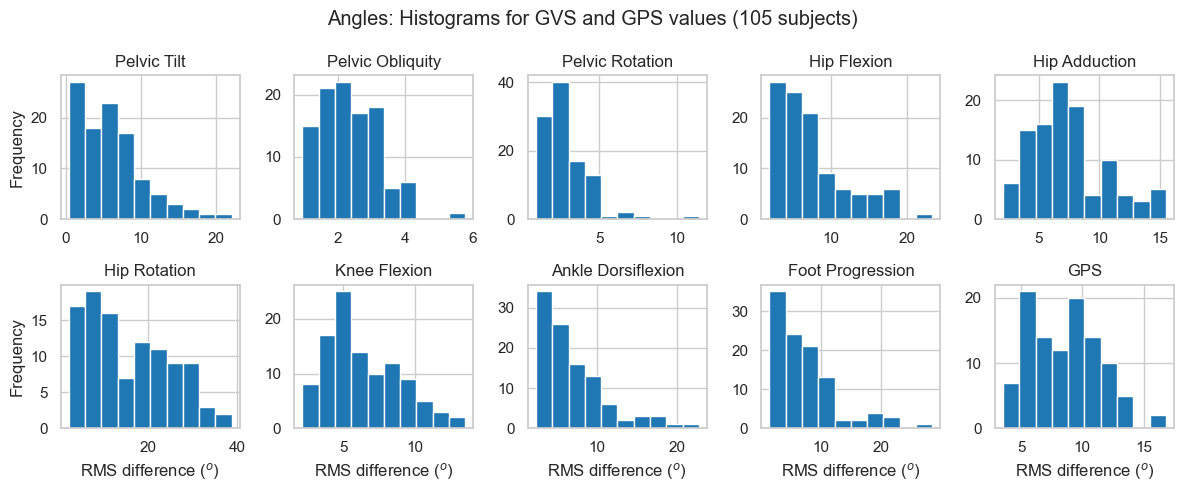

In [7]:
da2 = da_kin.dropna(dim='Subject', how='all').reduce(np.nanquantile, q=.5, dim='Trial') #da.reduce(np.nanmean, dim='Trial')
gvs, gvs_m, gvs_std = gps_calc(da2, ref_data_kin.iloc[:, 0::2], metadata, labels_gps=labels_gps_kin)
plot_gps(gvs, gvs_m, gvs_std, metadata, path2, hist=True, MAP=False, units='$^o$')

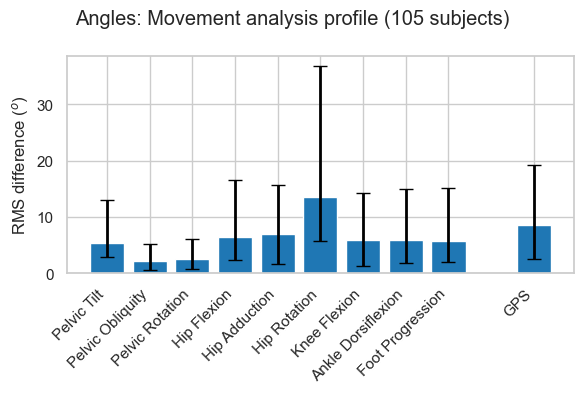

In [8]:
plot_gps(gvs, gvs_m, gvs_std, metadata, path2, hist=False, MAP=True, units='$^o$')

## The Gait Proﬁle Score with no offsets (GPSno)

In gait analysis, when comparing kinematics of different subjects, it's not uncommon that some of the possible differences may be due to artifacts from incorrect positioning of markers on the body, introducing a constant offset in the angles, for example. We will explore this possibility by making all the angles with mean zero  when computing the GPS. This is somewhat equivalent to calculating the standard deviation instead of the actual RMS between the two angles in the GPS.

In [9]:
prefix = 'No offsets - '
da2_no = da2 - da2.reduce(np.nanmean, dim='Time')

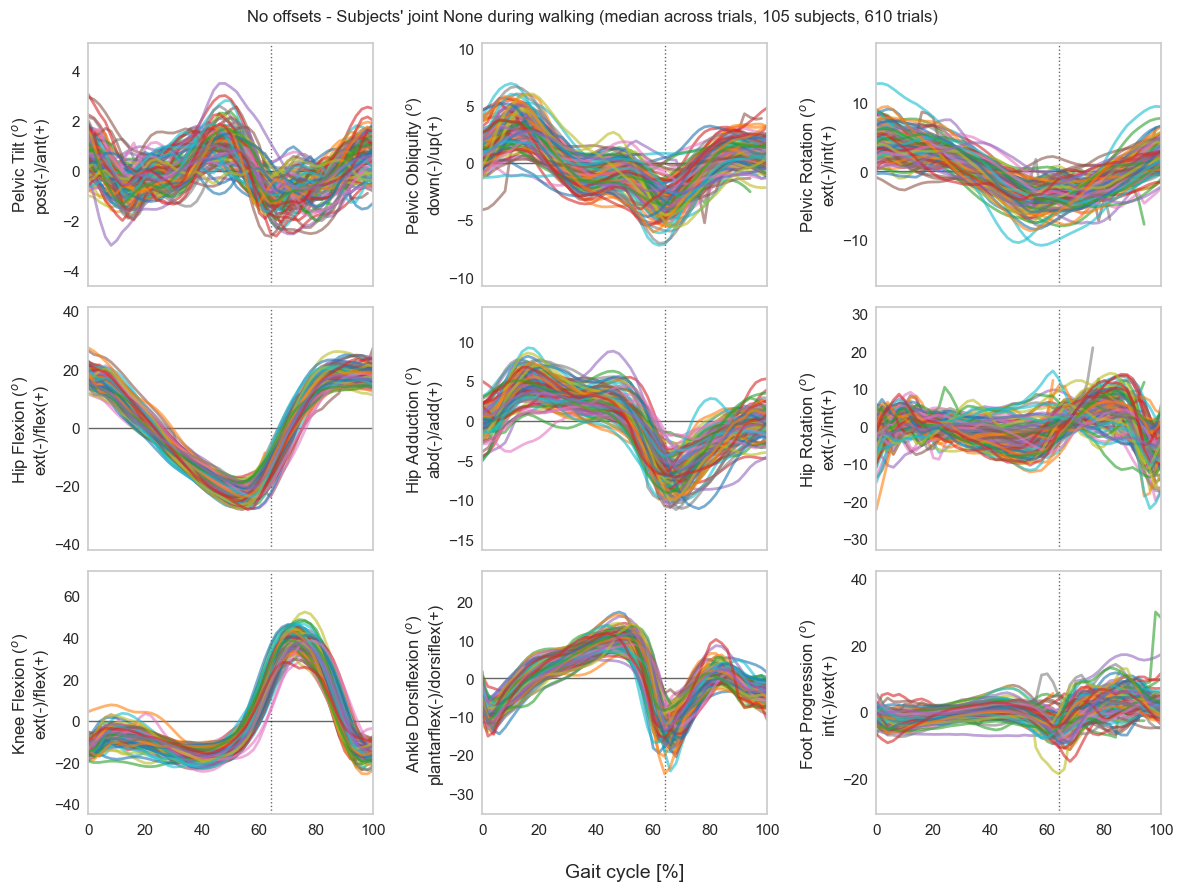

In [10]:
plot_ensembles(da2_no, metadata, path2, labels=labels_kin, prefix=prefix)

/var/folders/0k/7_22nvnx6jz2h52d8m58fgww0000gn/T/ipykernel_15999/573977029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_data_no.iloc[:, 0::2] = ref_data_kin.iloc[:, 0::2] - np.nanmean(ref_data_kin.iloc[:, 0::2], axis=0)
/var/folders/0k/7_22nvnx6jz2h52d8m58fgww0000gn/T/ipykernel_15999/573977029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_data_no.iloc[:, 1::2] = 0


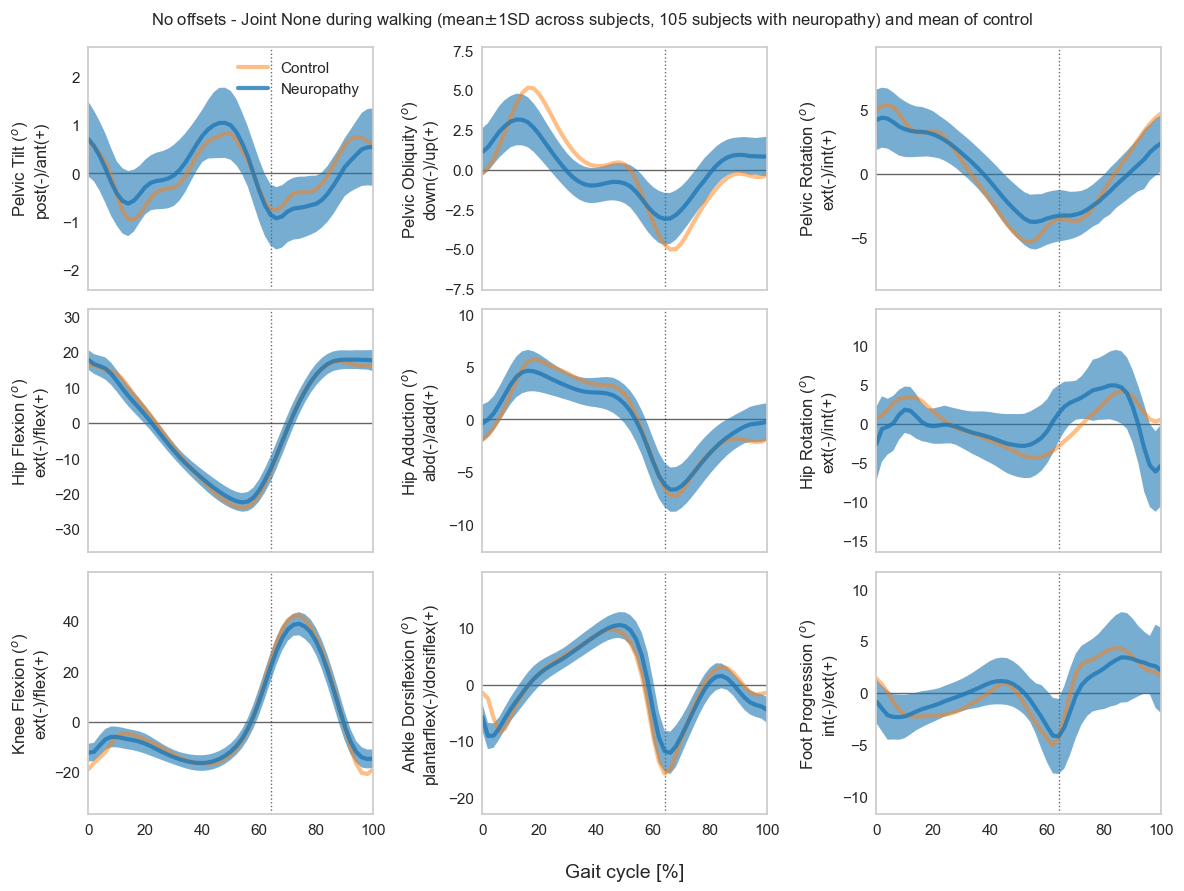

In [11]:
ref_data_no = ref_data_kin
ref_data_no.iloc[:, 0::2] = ref_data_kin.iloc[:, 0::2] - np.nanmean(ref_data_kin.iloc[:, 0::2], axis=0)
ref_data_no.iloc[:, 1::2] = 0
plot_ensembles(da2_no, metadata, path2, mean=True, labels=labels_kin, ref=ref_data_no, prefix=prefix)

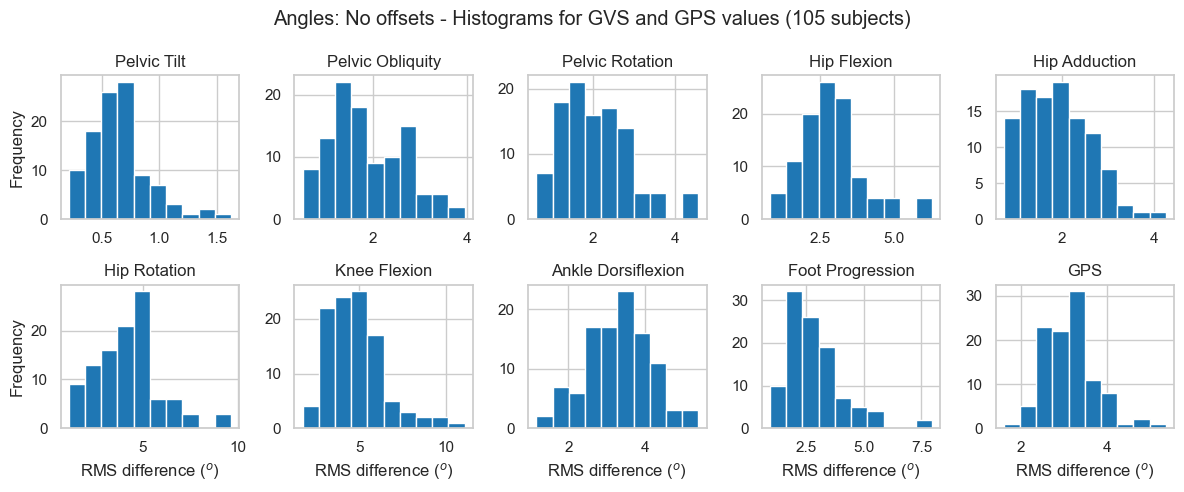

In [12]:
gvs_no, gvs_m_no, gvs_std_no = gps_calc(da2_no, ref_data_no.iloc[:, 0::2], metadata, labels_gps=labels_gps_kin)
plot_gps(gvs_no, gvs_m_no, gvs_std_no, metadata, path2, hist=True, MAP=False, prefix=prefix, units='$^o$')

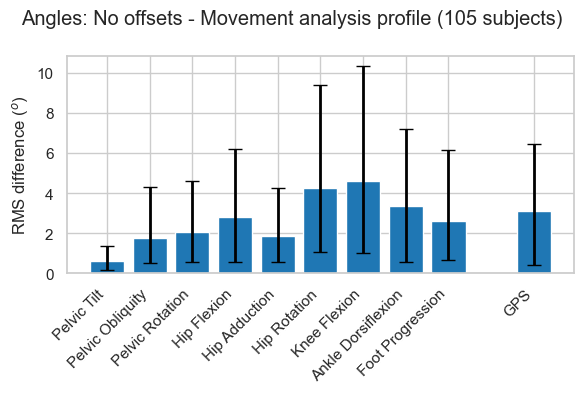

In [13]:
plot_gps(gvs_no, gvs_m_no, gvs_std_no, metadata, path2, hist=False, MAP=True, prefix=prefix, units='$^o$')

## GPS kinetic

<xarray.DataArray 'Moment' (Time: 51, Joint: 4, Axis: 1, Trial: 10, Subject: 105)> Size: 2MB
[214200 values with dtype=float64]
Coordinates:
  * Subject  (Subject) object 840B 'C02' 'C04' 'C06' 'C07' ... 'S68' 'S70' 'S71'
  * Time     (Time) float64 408B 0.0 2.0 4.0 6.0 8.0 ... 94.0 96.0 98.0 100.0
  * Trial    (Trial) int32 40B 0 1 2 3 4 5 6 7 8 9
  * Joint    (Joint) object 32B 'Hip' 'Knee' 'Ankle' 'Support'
  * Axis     (Axis) object 8B 'ML'
Attributes:
    units:    Nm/(BM*H)

/Users/marcos/miniconda3/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


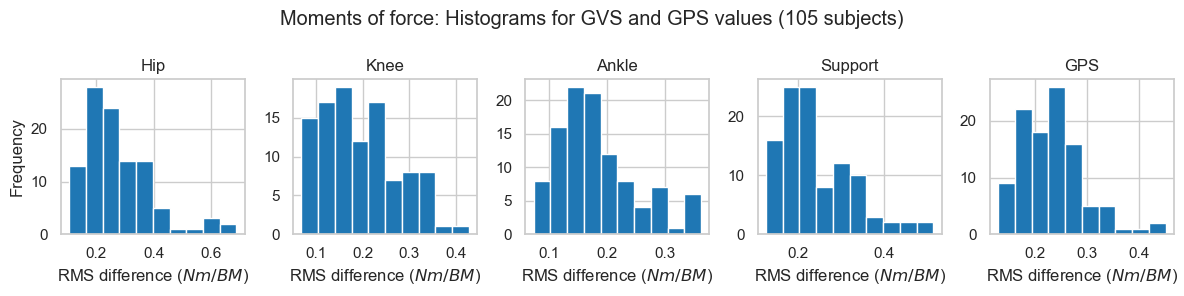

In [14]:
path2 = Path('./../data/')
variable = 'Moment'
metadata, da_mom = read_data(path2, fname='ERJ_T00', variable=variable)
display(da_mom)

da2 = da_mom.dropna(dim='Subject', how='all').reduce(np.nanquantile, q=.5, dim='Trial') #da.reduce(np.nanmean, dim='Trial')
gvs, gvs_m, gvs_std = gps_calc(da2, ref_data_mom.iloc[:, 0::2], metadata, labels_gps=labels_gps_mom)
plot_gps(gvs, gvs_m, gvs_std, metadata, path2, hist=True, MAP=False, units='$Nm/BM$')

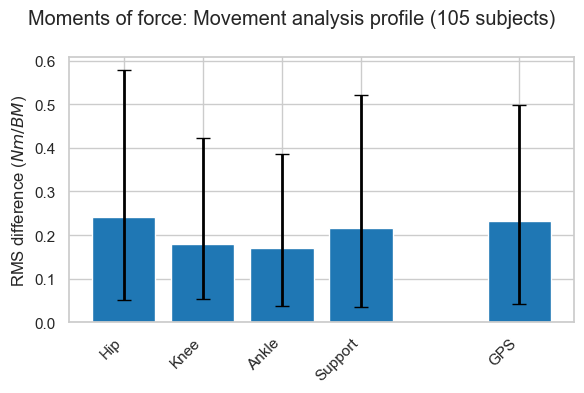

In [15]:
plot_gps(gvs, gvs_m, gvs_std, metadata, path2, hist=False, MAP=True, units='$Nm/BM$')